In [1]:
from VR_Trajectory_analysis import *

In [2]:
directory = '/Users/apaula/ownCloud/MatrexVR1/20241213_ants_size_bias_Data/RunData'

In [3]:
df = get_combined_df(directory, trim_seconds=1.0)

Processing subfolder: 20241217_134346
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20241213_ants_size_bias_Data/RunData/20241217_134346/20241217_134346_Forrest_choice_VR2_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20241213_ants_size_bias_Data/RunData/20241217_134346/20241217_134346_Choice_noBG_VR2_.csv
Processing subfolder: 20241218_154928
Processing subfolder: 20241219_165651
Processing subfolder: 20241219_123109
Processing subfolder: 20241216_152041
Processing subfolder: 20241217_144300
Processing subfolder: 20241216_131139
Processing subfolder: 20241218_142119
Processing subfolder: 20241219_141645
Processing subfolder: 20241216_154615
Processing subfolder: 20241216_113323
Processing subfolder: 20241216_172110
Processing subfolder: 20241218_141804
Processing subfolder: 20241218_132702
Processing subfolder: 20241219_132104
Processing subfolder: 20241218_122444
Processing subfolder: 20241219_112628
Processing subfolder: 20241217_143156
No JSON metadata file found

In [4]:
df["FlyID"].nunique()


56

In [5]:
df = add_trial_id_and_displacement(df)
df = add_trial_time(df)

In [6]:
df_stationary, df_normal, df_excessive, stationary_ids, normal_ids, excessive_ids = classify_trials_by_displacement(df[df['Scene']=='Choice_noBG'], min_disp=0, max_disp=500)

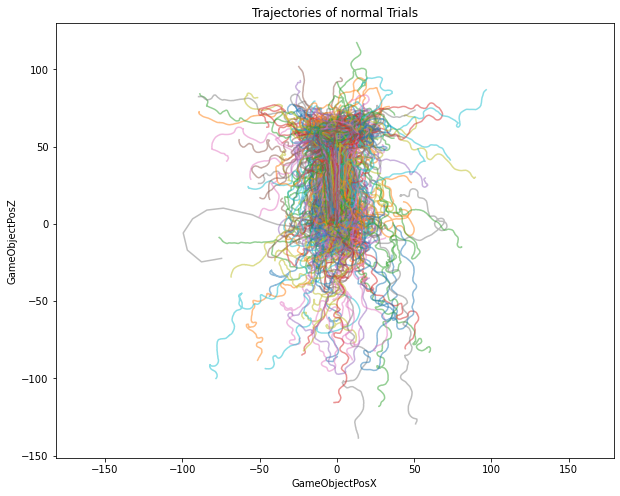

In [7]:
plot_trajectories(df_normal, 'normal')

In [9]:
# Define goal coordinates (same as before)
center_goal = (0, 60)
left_goal = (-10.416, 59.088)
right_goal = (10.416, 59.088)

# Threshold for reaching the goal
threshold = 4  # 4 cm

# Config files that have only the center goal
center_only_configs = [
    "BinaryChoice10_BlackCylinder_control.json",
    "BinaryChoice10_constantSize_BlackCylinder_control.json"
]

results_df = get_first_goal_reached(
    df_normal,  
    center_goal,
    left_goal,
    right_goal,
    threshold,
    center_only_configs
)

In [10]:
results_df.to_pickle("size_results_df.pkl")

In [27]:
results_df = pd.read_pickle("size_results_df.pkl")

In [36]:
results_df[results_df['FirstReachedGoal'].notna()]

,UniqueTrialID,ConfigFile,FirstReachedGoal,GoalReachedTime,GoalType
194,254,BinaryChoice11_constantSize_12deg_10deg.json,left,42.317,12deg
196,256,BinaryChoice11_constantSize_10deg_12deg.json,left,37.984,10deg
197,257,BinaryChoice10_constantSize_BlackCylinder_cont...,center,33.617,10deg
198,258,BinaryChoice11_constantSize_BlackCylinder_Blac...,left,33.918,10deg
200,260,BinaryChoice11_constantSize_10deg_12deg.json,left,31.001,10deg
...,...,...,...,...,...
4004,8025,BinaryChoice11_constantSize_10deg_15deg.json,left,41.483,10deg
4005,8026,BinaryChoice10_constantSize_BlackCylinder_cont...,center,30.649,10deg
4012,8033,BinaryChoice11_constantSize_15deg_10deg.json,left,33.400,15deg
4014,8035,BinaryChoice11_constantSize_12deg_10deg.json,right,33.217,10deg


In [26]:
config_map = {
    "BinaryChoice10_constantSize_BlackCylinder_control.json": ("10deg", "10deg"),
    "BinaryChoice11_constantSize_BlackCylinder_BlackCylinder.json": ("10deg", "10deg"),
    "BinaryChoice11_constantSize_10deg_12deg.json": ("10deg", "12deg"),
    "BinaryChoice11_constantSize_12deg_10deg.json": ("12deg", "10deg"),
    "BinaryChoice11_constantSize_10deg_15deg.json": ("10deg", "15deg"),
    "BinaryChoice11_constantSize_15deg_10deg.json": ("15deg", "10deg"),
    # etc...
}

def goal_type_from_config(config, reached_goal):
    if config not in config_map:
        return None

    left_deg, right_deg = config_map[config]

    if reached_goal == "left":
        return left_deg
    elif reached_goal == "right":
        return right_deg
    elif reached_goal == "center":
        return left_deg
    else:
        return None


In [33]:
results_df['GoalType'] = results_df.apply(
    lambda row: goal_type_from_config(row['ConfigFile'], row['FirstReachedGoal']),
    axis=1
)


In [41]:
# 1. Keep only trials that actually reached a goal
valid_results = results_df.dropna(subset=['FirstReachedGoal'])

# 2. Merge the cutoff times back into df
#    We merge on 'UniqueTrialID' to get each trial's GoalReachedTime.
df_merged = pd.merge(df, valid_results[['UniqueTrialID', 'GoalReachedTime', 'FirstReachedGoal']], on='UniqueTrialID', how='inner')

# 3. Filter df so that only rows with trial_time less than or equal to the goal time are kept
df_cut = df_merged[df_merged['trial_time'] <= df_merged['GoalReachedTime']]

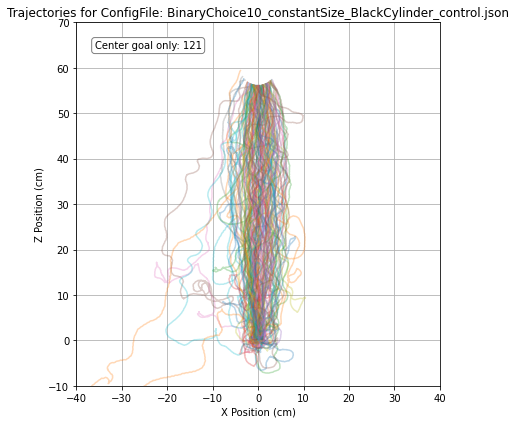

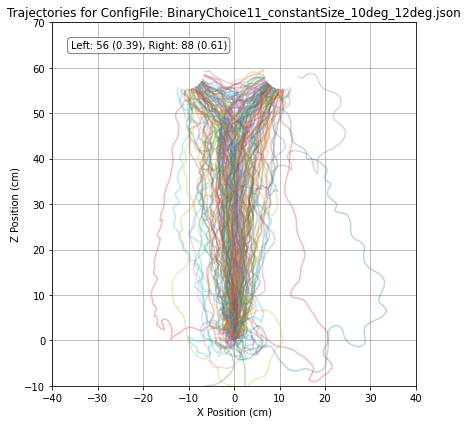

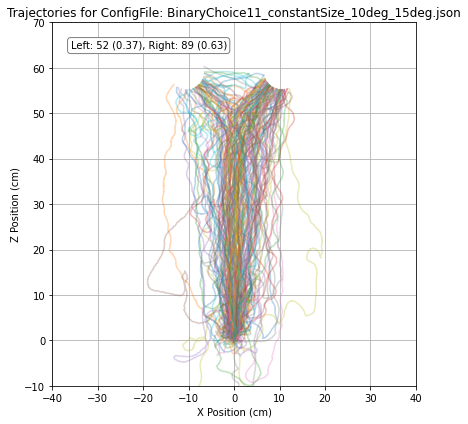

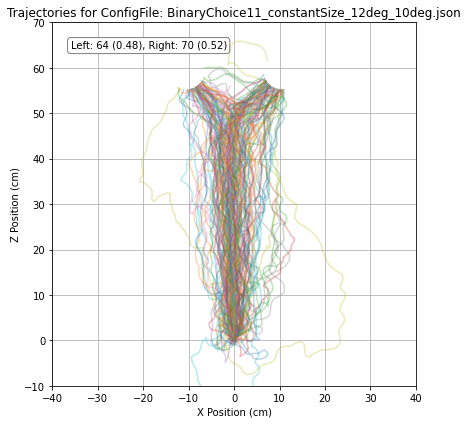

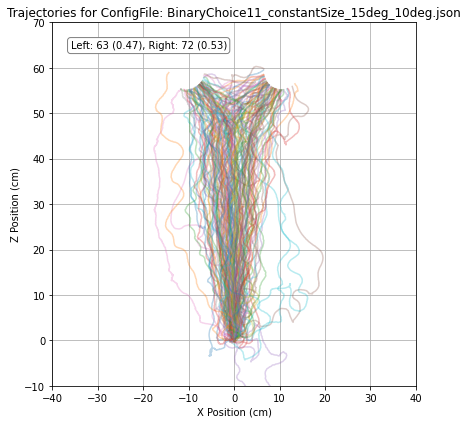

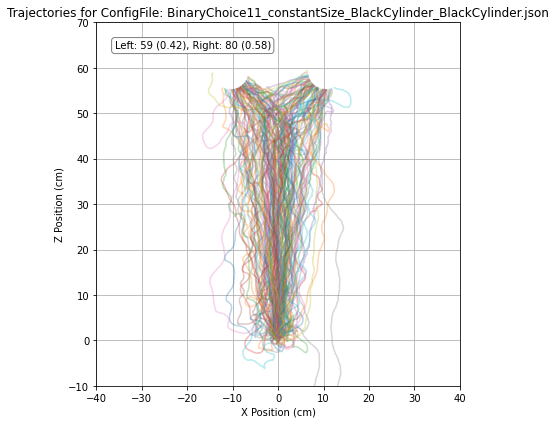

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these from previous steps:
center_only_configs = [
    "BinaryChoice10_BlackCylinder_control.json",
    "BinaryChoice10_constantSize_BlackCylinder_control.json"
]

# Identify which ConfigFiles have multiple goals
# Since we know only the two listed above are single-goal configs,
# all others are multi-goal configs.
all_configs = df_cut['ConfigFile'].unique()
multi_goal_configs = [c for c in all_configs if c not in center_only_configs]

# Merge results_df to get the goal reached information into df_cut if needed
# (Not strictly necessary if we only need ratios. We can just use results_df separately.)
# But let's have a convenient DataFrame for ratio calculations.
df_joined = pd.merge(df_cut, results_df[['UniqueTrialID', 'FirstReachedGoal']], on='UniqueTrialID', how='left')

# Group the truncated data by ConfigFile
for config, group in df_joined.groupby('ConfigFile'):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot each trial’s trajectory
    for trial_id, trial_data in group.groupby('UniqueTrialID'):
        ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)
    
    ax.set_ylim(-10, 70)
    ax.set_xlim(-40, 40)
    
    # Make axes equal
    ax.set_aspect('equal', adjustable='box')

    # Set plot titles and labels
    ax.set_title(f"Trajectories for ConfigFile: {config}")
    ax.set_xlabel("X Position (cm)")
    ax.set_ylabel("Z Position (cm)")
    ax.grid(True)
    
    # If it's a multi-goal config, calculate ratio left/right
    if config in multi_goal_configs:
        # Filter the trials for this config in results_df
        config_results = results_df.loc[results_df['UniqueTrialID'].isin(group['UniqueTrialID'].unique())]
        
        # Count how many reached left vs right
        left_count = (config_results['FirstReachedGoal'] == 'left').sum()
        right_count = (config_results['FirstReachedGoal'] == 'right').sum()
        
        # Compute ratio (e.g., left/total and right/total)
        total = left_count + right_count
        if total > 0:
            left_ratio = left_count / total
            right_ratio = right_count / total
            ratio_text = f"Left: {left_count} ({left_ratio:.2f}), Right: {right_count} ({right_ratio:.2f})"
        else:
            ratio_text = "No goals reached"
        
        # Add text box with ratio information
        ax.text(0.05, 0.95, ratio_text, transform=ax.transAxes, va='top', bbox=dict(boxstyle="round", fc="w", ec="0.5"))
    
    elif config in center_only_configs:
        # Filter the trials for this config in results_df
        config_results = results_df.loc[results_df['UniqueTrialID'].isin(group['UniqueTrialID'].unique())]
        
        # Count how many reached left vs right
        count = (config_results['FirstReachedGoal'] == 'center').sum()
        # Only center goal, no ratio needed
        ax.text(0.05, 0.95, f"Center goal only: {count}", transform=ax.transAxes, va='top', bbox=dict(boxstyle="round", fc="w", ec="0.5"))
    
    
    output_dir = '/Users/apaula/Downloads'
    # Remove '.json' from config filename and prepend 'trajectories_'
    base_name = os.path.splitext(config)[0]
    filename = f"trajectories2_{base_name}.png"
    filepath = os.path.join(output_dir, filename)
    
    # Save the figure
    fig.savefig(filepath, dpi=300)

    plt.tight_layout()
    plt.show()

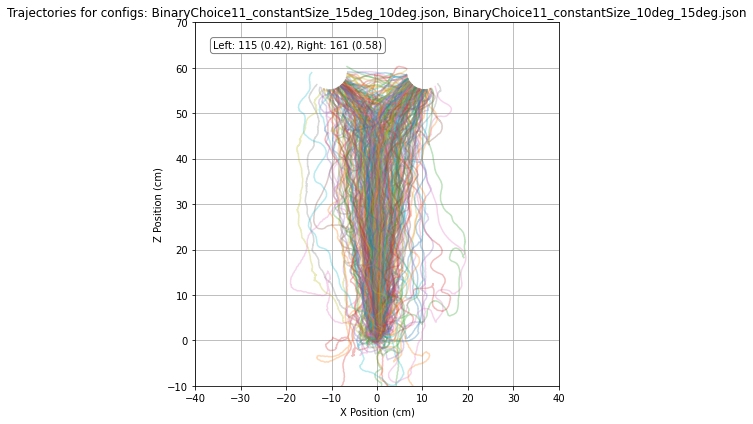

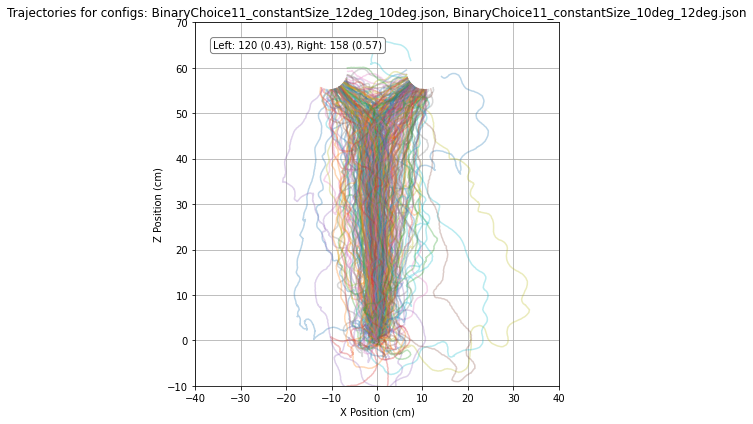

In [43]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Define the groups of configurations you want to plot together
group1_configs = [
    "BinaryChoice11_constantSize_15deg_10deg.json",
    "BinaryChoice11_constantSize_10deg_15deg.json"
]

group2_configs = [
    "BinaryChoice11_constantSize_12deg_10deg.json",
    "BinaryChoice11_constantSize_10deg_12deg.json"
]

output_dir = '/Users/apaula/Downloads'

def plot_group_of_configs(config_list, group_name, df_joined, results_df):
    # Filter df_joined for only these configs
    group_df = df_joined[df_joined['ConfigFile'].isin(config_list)]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot each trial’s trajectory
    for trial_id, trial_data in group_df.groupby('UniqueTrialID'):
        ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)
    
    # Set axes limits and aspect
    ax.set_ylim(-10, 70)
    ax.set_xlim(-40, 40)
    ax.set_aspect('equal', adjustable='box')
    
    # Title and labels
    ax.set_title(f"Trajectories for configs: {', '.join(config_list)}")
    ax.set_xlabel("X Position (cm)")
    ax.set_ylabel("Z Position (cm)")
    ax.grid(True)
    
    # Compute the ratio of left/right goals for these combined configs
    # Filter results_df for trials in this group
    group_trial_ids = group_df['UniqueTrialID'].unique()
    group_results = results_df[results_df['UniqueTrialID'].isin(group_trial_ids)]
    
    # Count how many reached left vs right
    left_count = (group_results['FirstReachedGoal'] == 'left').sum()
    right_count = (group_results['FirstReachedGoal'] == 'right').sum()
    center_count = (group_results['FirstReachedGoal'] == 'center').sum()
    
    total = left_count + right_count + center_count
    if total > 0:
        if (left_count + right_count) > 0:
            left_ratio = left_count / total
            right_ratio = right_count / total
            ratio_text = f"Left: {left_count} ({left_ratio:.2f}), Right: {right_count} ({right_ratio:.2f})"
        else:
            # If this set is supposed to have multiple goals and no center in theory,
            # but center_count is nonzero, just show center count
            ratio_text = f"Center: {center_count}"
    else:
        ratio_text = "No goals reached"
    
    # Add text box with ratio information
    ax.text(0.05, 0.95, ratio_text, transform=ax.transAxes, va='top',
            bbox=dict(boxstyle="round", fc="w", ec="0.5"))
    
    # Save the figure
    filename = f"trajectories2_{group_name}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300)
    plt.tight_layout()
    plt.show()

# Now call the function for each group
plot_group_of_configs(group1_configs, "group1", df_joined, results_df)
plot_group_of_configs(group2_configs, "group2", df_joined, results_df)



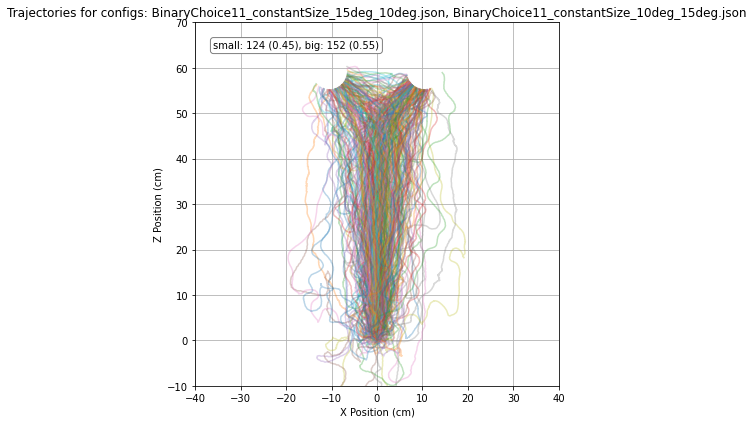

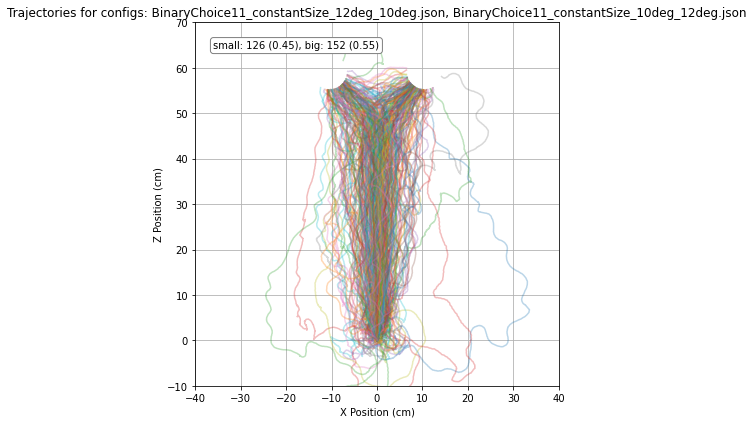

In [46]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Define the groups of configurations you want to plot together
group1_configs = [
    "BinaryChoice11_constantSize_15deg_10deg.json",
    "BinaryChoice11_constantSize_10deg_15deg.json"
]

group2_configs = [
    "BinaryChoice11_constantSize_12deg_10deg.json",
    "BinaryChoice11_constantSize_10deg_12deg.json"
]

# Define which configs should have their X inverted
invert_x_configs = {
    "BinaryChoice11_constantSize_15deg_10deg.json",
    "BinaryChoice11_constantSize_12deg_10deg.json"
}

output_dir = '/Users/apaula/Downloads'

def plot_group_of_configs(config_list, group_name, df_joined, results_df):
    # Filter df_joined for only these configs
    group_df = df_joined[df_joined['ConfigFile'].isin(config_list)]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for config, cfg_group in group_df.groupby('ConfigFile'):
        # Check if this config should have its X values inverted
        if config in invert_x_configs:
            # Make a copy to avoid altering the original dataframe
            cfg_group = cfg_group.copy()
            cfg_group['GameObjectPosX'] = -cfg_group['GameObjectPosX']
        
        # Plot each trial’s trajectory for this config
        for trial_id, trial_data in cfg_group.groupby('UniqueTrialID'):
            ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)
    
    # Set axes limits and aspect
    ax.set_ylim(-10, 70)
    ax.set_xlim(-40, 40)
    ax.set_aspect('equal', adjustable='box')
    
    # Title and labels
    ax.set_title(f"Trajectories for configs: {', '.join(config_list)}")
    ax.set_xlabel("X Position (cm)")
    ax.set_ylabel("Z Position (cm)")
    ax.grid(True)
    
    # Compute the ratio of black/grey goals for these combined configs
    group_trial_ids = group_df['UniqueTrialID'].unique()
    group_results = results_df[results_df['UniqueTrialID'].isin(group_trial_ids)]
    
    ten_deg_count = (group_results['GoalType'] == '10deg').sum()
    fifteen_deg_count = (group_results['GoalType'] == '15deg').sum()+(group_results['GoalType'] == '12deg').sum()
    
    total = ten_deg_count + fifteen_deg_count
    if total > 0:
        if (ten_deg_count + fifteen_deg_count) > 0:
            small_ratio = ten_deg_count / total
            big_ratio = fifteen_deg_count / total
            ratio_text = f"small: {ten_deg_count} ({small_ratio:.2f}), big: {fifteen_deg_count} ({big_ratio:.2f})"
        else:
            ratio_text = f""
    else:
        ratio_text = "No goals reached"
    
    # Add text box with ratio information
    ax.text(0.05, 0.95, ratio_text, transform=ax.transAxes, va='top',
            bbox=dict(boxstyle="round", fc="w", ec="0.5"))
    
    # Save the figure
    filename = f"trajectories_{group_name}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300)
    
    plt.tight_layout()
    plt.show()

# Now call the function for each group
plot_group_of_configs(group1_configs, "group1", df_joined, results_df)
plot_group_of_configs(group2_configs, "group2", df_joined, results_df)

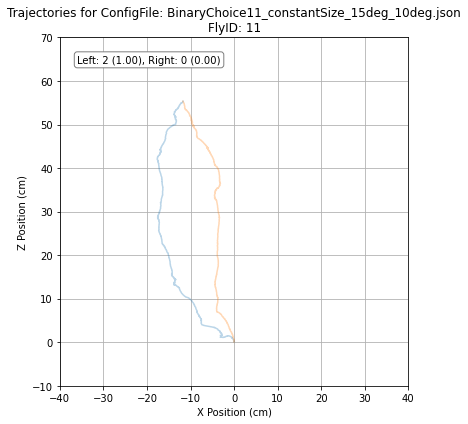

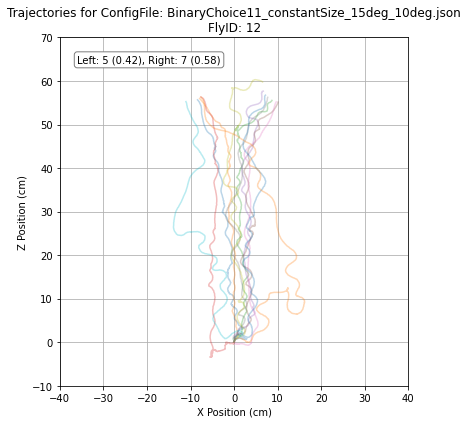

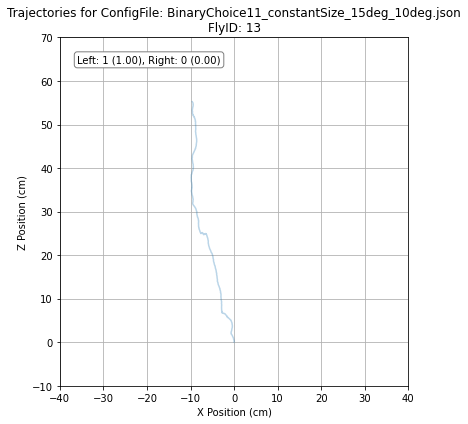

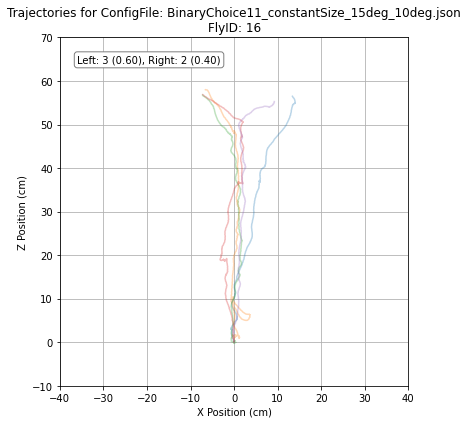

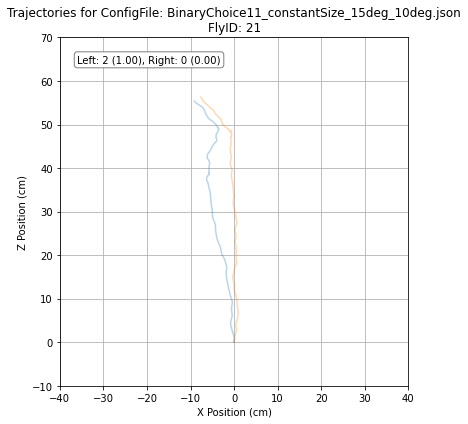

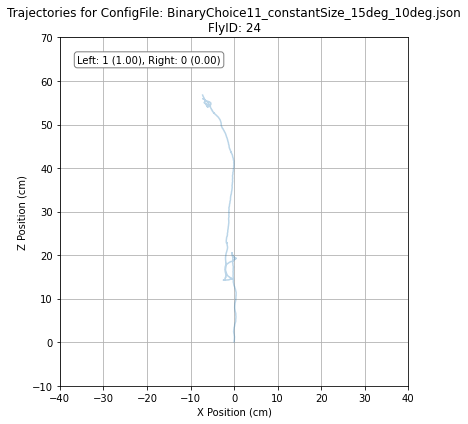

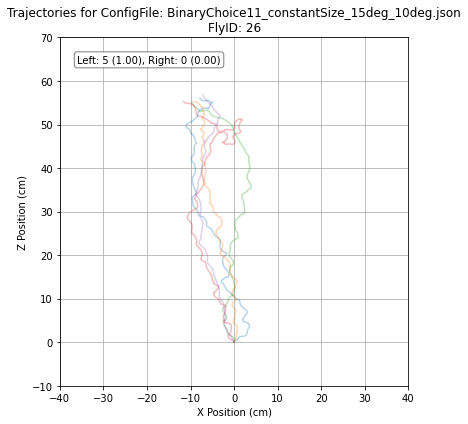

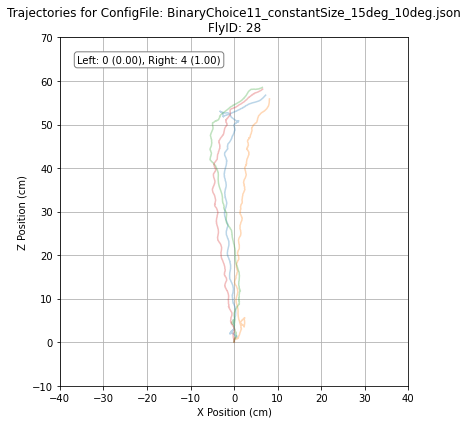

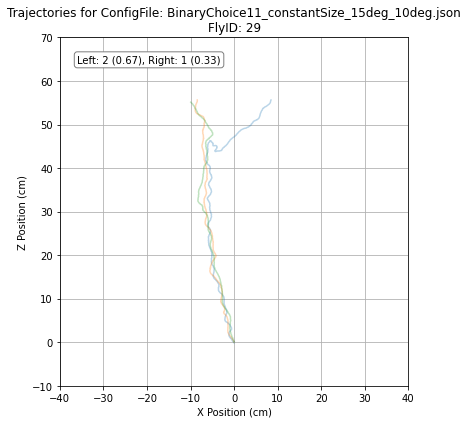

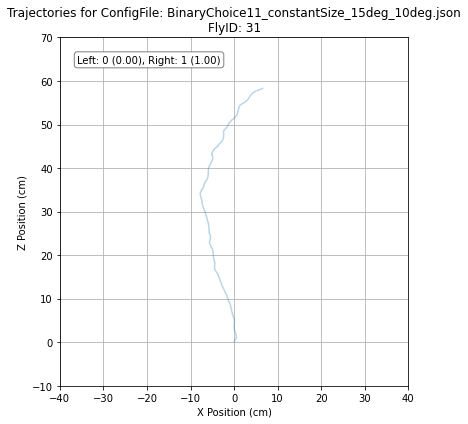

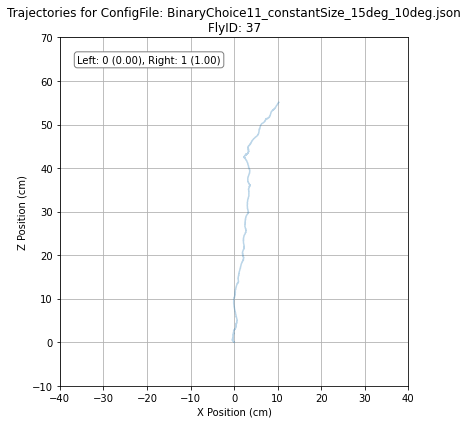

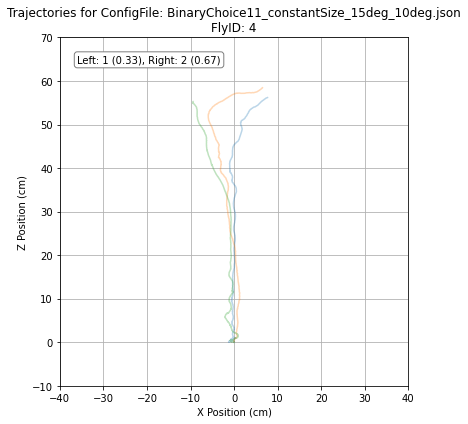

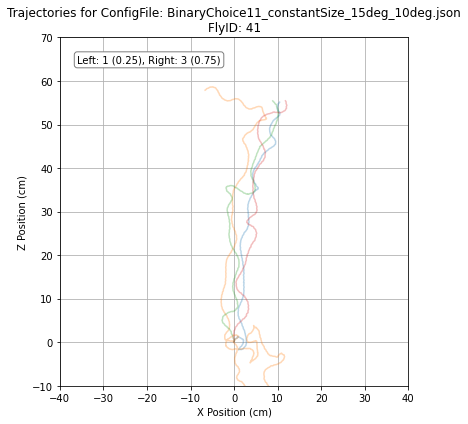

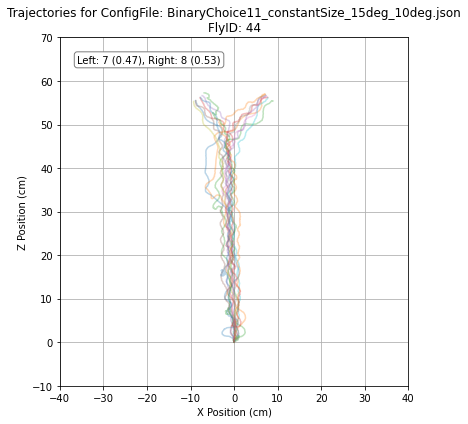

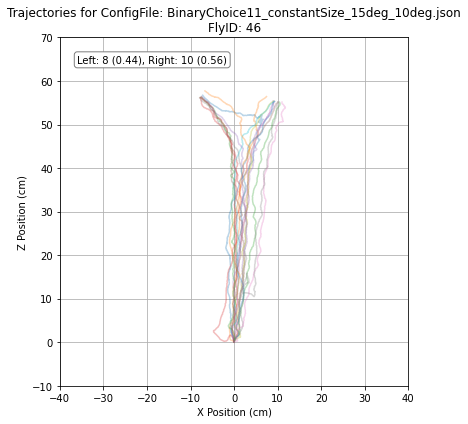

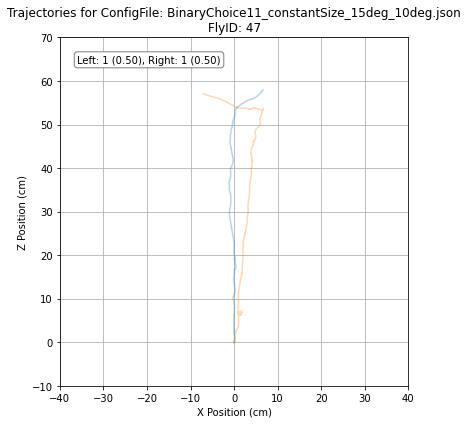

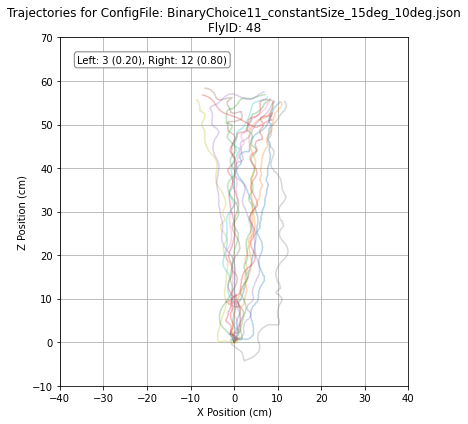

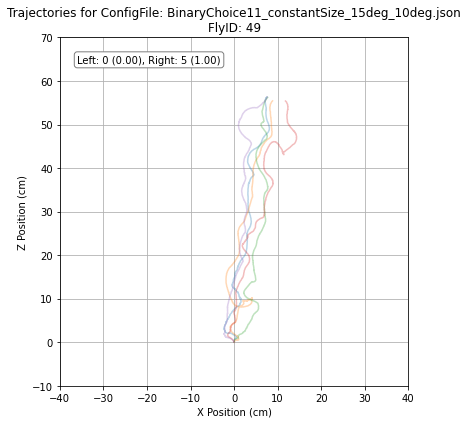

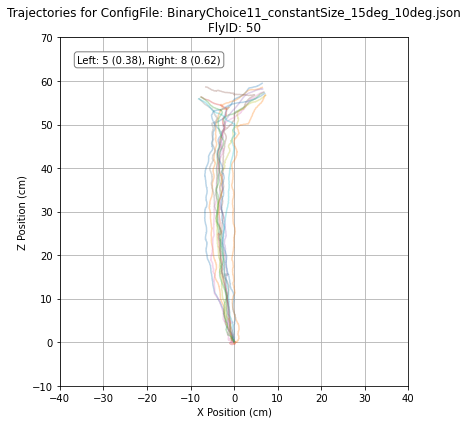

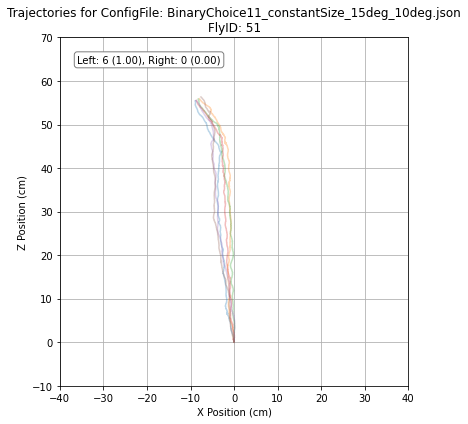

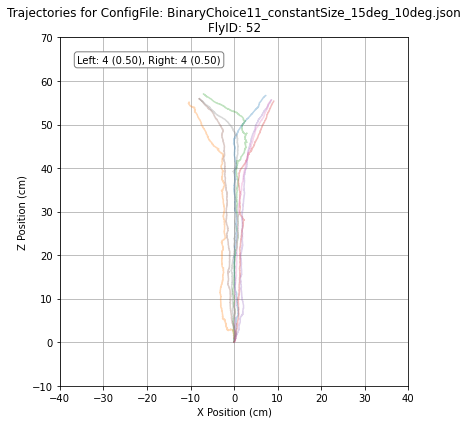

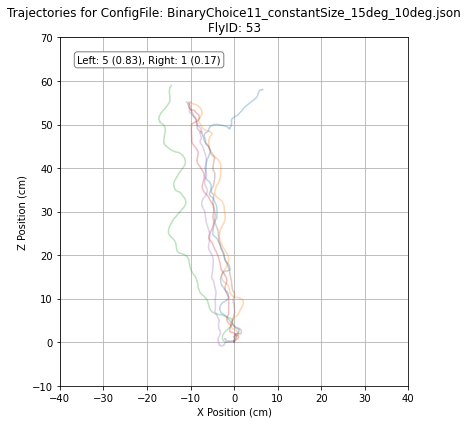

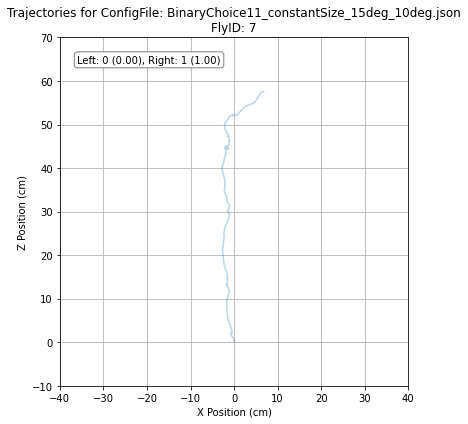

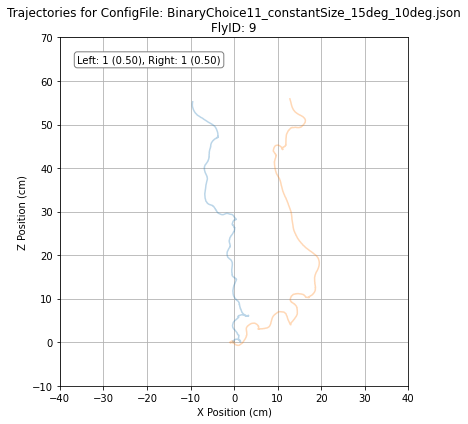

In [49]:
df_joined = pd.merge(df_cut, results_df[['UniqueTrialID', 'FirstReachedGoal']], on='UniqueTrialID', how='left')

import os
import matplotlib.pyplot as plt
import pandas as pd

# Specify which config you want to plot
config_of_interest = "BinaryChoice11_constantSize_15deg_10deg.json"

# Subset df_joined to only the config of interest
df_config = df_joined[df_joined["ConfigFile"] == config_of_interest].copy()

# Check if it's a multi-goal config or a center-only config
is_multi_goal = config_of_interest not in center_only_configs

# Create an output directory if needed
output_dir = '/Users/apaula/Downloads/sizebias'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Group by FlyID
for fly_id, group_fly in df_config.groupby('FlyID'):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each trial’s trajectory for this FlyID
    for trial_id, trial_data in group_fly.groupby('UniqueTrialID'):
        ax.plot(trial_data['GameObjectPosX'], trial_data['GameObjectPosZ'], alpha=0.3)

    # Set axis limits (adjust as needed)
    ax.set_ylim(-10, 70)
    ax.set_xlim(-40, 40)
    
    # Make axes equal
    ax.set_aspect('equal', adjustable='box')

    # Title and labels
    ax.set_title(f"Trajectories for ConfigFile: {config_of_interest}\nFlyID: {fly_id}")
    ax.set_xlabel("X Position (cm)")
    ax.set_ylabel("Z Position (cm)")
    ax.grid(True)

    # -----------------------------------------------------------
    # If it's a multi-goal config, calculate ratio left/right
    # -----------------------------------------------------------
    if is_multi_goal:
        # Filter the trials for this FlyID in results_df
        fly_results = results_df.loc[results_df['UniqueTrialID'].isin(group_fly['UniqueTrialID'].unique())]
        
        # Count how many reached left vs right
        left_count = (fly_results['FirstReachedGoal'] == 'left').sum()
        right_count = (fly_results['FirstReachedGoal'] == 'right').sum()
        
        # Compute ratio (e.g., left/total and right/total)
        total = left_count + right_count
        if total > 0:
            left_ratio = left_count / total
            right_ratio = right_count / total
            ratio_text = f"Left: {left_count} ({left_ratio:.2f}), Right: {right_count} ({right_ratio:.2f})"
        else:
            ratio_text = "No goals reached"
        
        # Add text box with ratio information
        ax.text(
            0.05, 0.95, ratio_text, 
            transform=ax.transAxes, va='top', 
            bbox=dict(boxstyle="round", fc="w", ec="0.5")
        )
    
    # -----------------------------------------------------------
    # If it's a single (center) goal config
    # -----------------------------------------------------------
    else:
        # Filter the trials for this FlyID in results_df
        fly_results = results_df.loc[results_df['UniqueTrialID'].isin(group_fly['UniqueTrialID'].unique())]
        
        # Count how many reached 'center'
        center_count = (fly_results['FirstReachedGoal'] == 'center').sum()
        
        ax.text(
            0.05, 0.95, f"Center goal only: {center_count}", 
            transform=ax.transAxes, va='top',
            bbox=dict(boxstyle="round", fc="w", ec="0.5")
        )
    
    # -----------------------------------------------------------
    # Save and show
    # -----------------------------------------------------------
    base_name = os.path.splitext(config_of_interest)[0]
    filename = f"trajectories_{base_name}_FlyID_{fly_id}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=300)

    plt.tight_layout()
    plt.show()